In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import imp
import sys
sys.path.insert(0,'/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
sys.path.append('/home/robin/Projects/simrest_validation')
sys.path.append('/home/robin/Projects/INM6/Tasks/')
from viziphant.plots.rasterplot import rasterplot
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
from networkunit import models, tests, scores
from networkunit.plots import alpha
import seaborn as sns
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
rc('text', usetex=True)
font_size = 24
text_size = 26

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1359: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Homogenous Poisson Process

In [2]:
size = 20
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_hpp = models.stochastic_activity(size=size, correlations=0., assembly_sizes=[],
                                correlation_method='CPP', name='HPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

/usr/local/lib/python2.7/dist-packages/quantities/quantity.py:321: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)


(0.98131487965583808, 0.55538641635109398, 0.38740485135246722)


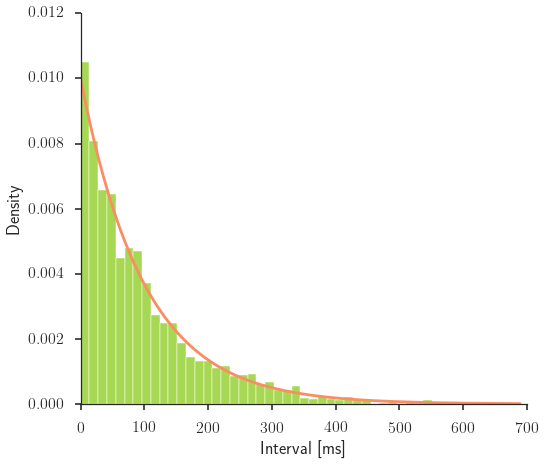

In [ ]:
intervals = np.array([])
for st in model_hpp.spiketrains:
    intervals = np.append(intervals,isi(st))
hist, edges = np.histogram(intervals, bins=50, density=True)

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
# fig.tight_layout()
sns.despine()

print sns.color_palette('Set2')[1]

ax.bar(edges[:-1], hist, width=np.diff(edges)[0], color=sns.color_palette('Set2')[4], edgecolor='w')
x = np.linspace(0,edges[-1],200)
mean_int = 1./rate
nu = 1./float(mean_int.rescale('ms'))
y = [nu * np.exp(-nu*t) for t in x]
ax.plot(x,y, color=sns.color_palette('Set2')[1])
ax.set_xlabel('Interval [ms]')
ax.set_ylabel('Density')
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/HPP_isi_dist.png')

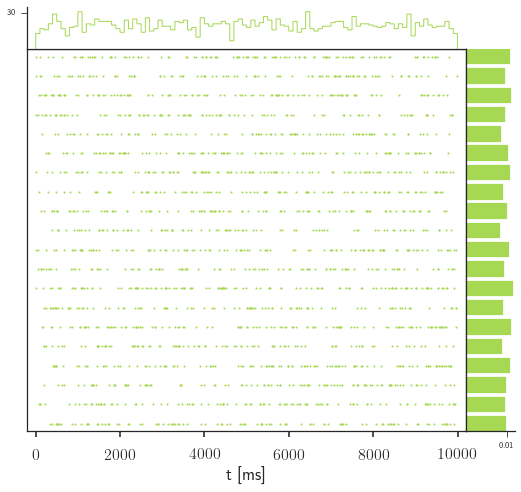

In [4]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

rasterplot(model_hpp.spiketrains, ax=ax, palette=[sns.color_palette('Set2')[4]],
           spacing=2, pophist_mode='total', key_list=['Model'],
           labelkey=1)
# ax.set_ylabel('HPP')
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/rasterplot_hpp.png')

## Compound Poisson Process

In [5]:
size = 20
A = 10
cc = .7
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

0.193636862315


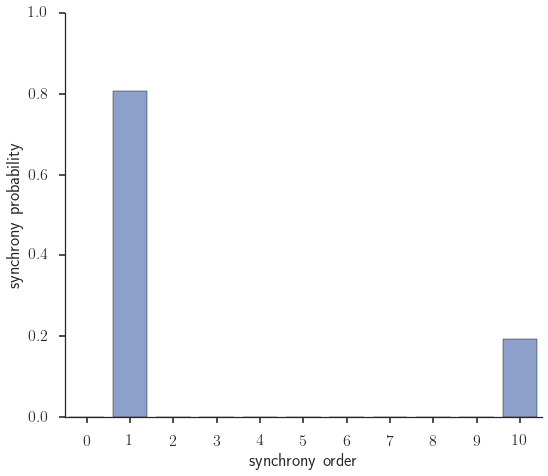

In [6]:
syncprob = model_cpp._correlation_to_syncprob(cc=cc, A_size=A, rate=rate, T=tstop - tstart,
                                              binsize=binsize)
print syncprob

sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
A_dist = [0] * (A+1)
A_dist[A] = syncprob
A_dist[1] = 1 - syncprob
width = .8
xvalues = np.arange(A+1) - width/2.
ax.bar(xvalues, A_dist, width=.8, color=sns.color_palette('Set2')[2])
ax.set_xlim(-0.5,A+.5)
ax.set_ylim(0, 1)
ax.set_xlabel('synchrony order')
ax.set_ylabel('synchrony probability')
ax.set_xticks(np.arange(A+1))
sns.despine()
fig.tight_layout()
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/amplitude_dist.png')

(0.65371782148585622, 0.84708959004458262, 0.32827375098770734)
#a7d854
(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)
#8da0cb


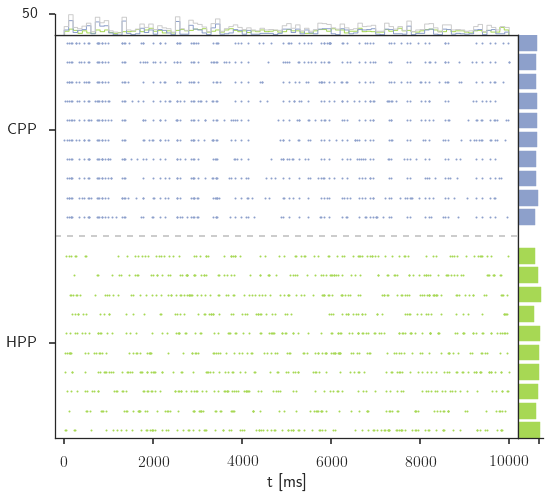

In [7]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

assembly_colors = [sns.color_palette('Set2')[4], sns.color_palette('Set2')[2]]
for c in assembly_colors:
    print c
    r,g,b = [int(round(ci*255)) for ci in c]
    print "#{:02x}{:02x}{:02x}".format(r,g,b)

model_cpp.show_rasterplot(ax=ax, palette=assembly_colors, 
                          key_list=['Assembly'], colorkey='Assembly', pophist_mode='color', context='poster', 
                          groupingdepth=1, spacing=1, labelkey=0, histscale=0.05)
plt.gca().set_xticklabels([''])
ax.set_yticklabels(['HPP', 'CPP'])
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/rasterplot_cpp.png')

## Reverse CPP

In [41]:
size = 20
A = 4
cc = .7
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
c_hoc = sns.color_palette('Set2')[2]
c_pwc = sns.color_palette('Set2')[4]
model_hoc = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='HOC', color=c_hoc)
for i in range(A):
    model_hoc.spiketrains[i].annotations['Assembly'] = 'A'
model_pwc = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='pairwise_equivalent', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='PWC', color=c_pwc)

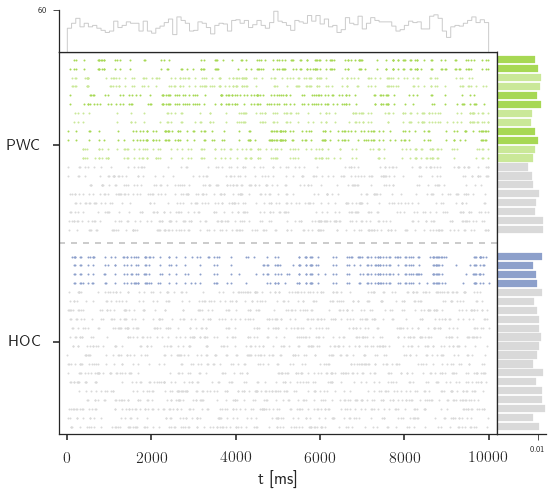

In [42]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

colors = [alpha('#000000',.15)] + [c_hoc] + [alpha(c_pwc,.6),c_pwc] * size

rasterplot(model_hoc.spiketrains + model_pwc.spiketrains, ax=ax, key_list=['Model', 'Assembly'], 
           groupingdepth=1, spacing=2, palette=colors, colorkey='Assembly', pophist_mode='total',
           labelkey=0)
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/rasterplot_reverse_cpp.png')

In [43]:
from networkunit.tests.base_tests import correlation_test, model2model_test

class m2m_cov_ks_test_2msbins_100sample(correlation_test, model2model_test):
    score_type = scores.ks_distance
    params = {'max_subsamplesize': 100,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms}

test = m2m_cov_ks_test_2msbins_100sample(model_pwc)

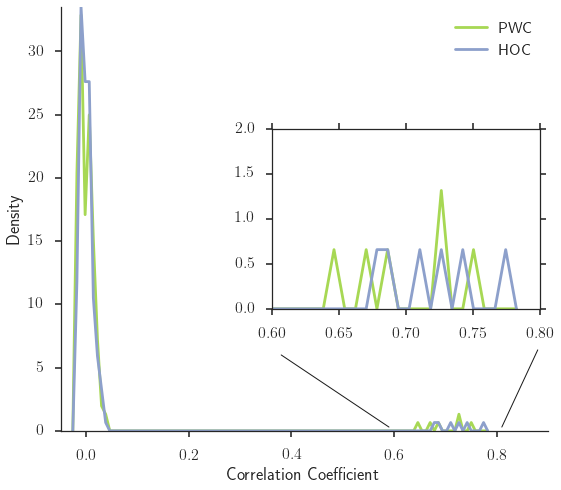

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

test.visualize_sample(model=model_hoc, ax=ax, var_name='Correlation Coefficient', sample_names=['PWC','HOC']);
ax.set_xlim((-.05,.9))
sns.despine()

insaxes = inset_axes(ax, width="55%", height=2.5, loc=5)
test.visualize_sample(model=model_hoc, ax=insaxes)

insaxes.set_xlim((0.6,0.8))
insaxes.set_ylim(0,2)
insaxes.set_xlabel('')
insaxes.set_ylabel('')
insaxes.legend().set_visible(False)

ax.plot([.38, .59], [6, .3], 'k-', lw=1)
ax.plot([.81, .88], [.3, 6.4], 'k-', lw=1)

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/cc_dist_reverse_cpp.png')

## Vine

In [123]:
size = 40
A = 8
cc = .7
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

c_cpp = sns.color_palette('Set2')[2]
c_vine = sns.color_palette('Set2')[3]

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

def vine(cc_mat):
    d = len(cc_mat)
    P = np.zeros((d,d))          # storing partial correlations
    S = np.eye(d)
    part_ccs = np.triu(cc_mat,1).flatten()
    np.random.shuffle(part_ccs)
    for k in range(d):
        for i in np.arange(k+1, d):
            P[k,i] = part_ccs[k*d + i - 0.5 * (k+1)*(k+2)]
            p = P[k,i]
            for l in np.arange(k-1,0,-1): # converting partial correlation to raw correlation
                p = p * np.sqrt((1.-P[l,i]**2)*(1.-P[l,k]**2)) + P[l,i]*P[l,k]
            if not np.isfinite(p):
                p = 0
            S[k,i] = p
            S[i,k] = p
    # permuting the variables to make the distribution permutation-invariant
    # permutation = np.random.permutation(d)
    # S = S[permutation][permutation]
    return S

In [124]:
from validation.matrix import corr_matrix, plot_matrix

cpp_mat = corr_matrix(model_cpp.spiketrains, binsize=binsize)
vine_mat = vine(cpp_mat)

vmin=-.2
vmax=.8

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


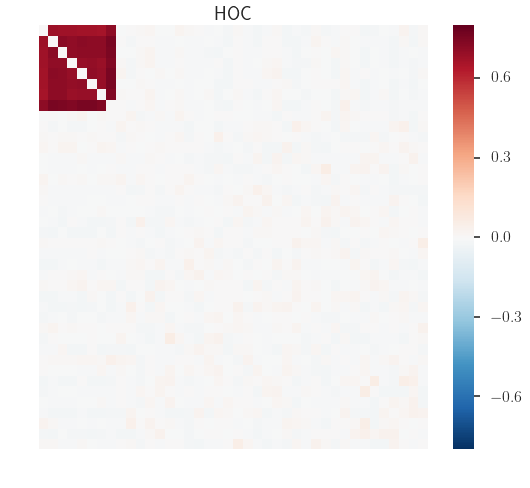

In [127]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()
plot_matrix(cpp_mat, ax=ax, remove_autocorr=True, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.set_title('HOC')

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccmatrix_cpp.png')

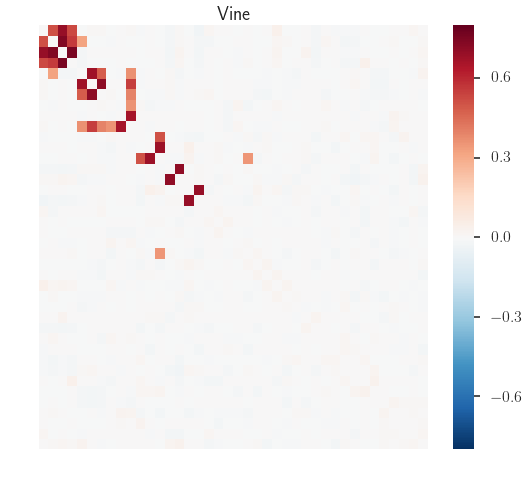

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

plot_matrix(vine_mat, ax=ax, remove_autocorr=True, cluster=True, vmin=vmin, vmax=vmax)#, sort=True)
ax.axis('off')
ax.set_title('Vine')
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccmatrix_vine.png')

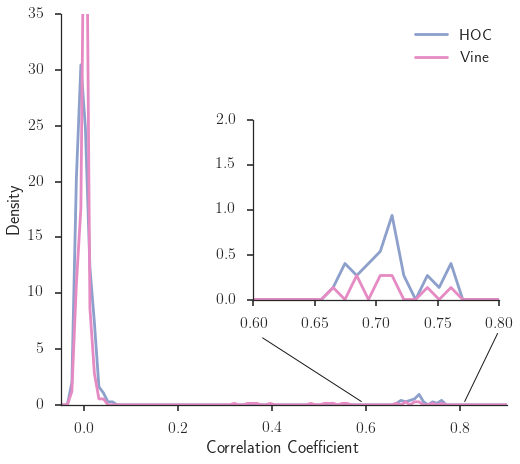

In [128]:
test = m2m_cov_ks_test_2msbins_100sample(model_cpp)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
edges = np.linspace(-.05,.9,100)
test.visualize_sample(ax=ax, bins=edges, palette=[c_cpp], var_name='Correlation Coefficient', sample_names=['HOC'])
hist, _ = np.histogram(vine_mat[np.triu_indices(len(vine_mat), 1)], bins=edges, density=True)
hist = np.append(np.append(0., hist), 0.)
dx = np.diff(edges)[0]
xvalues = edges[:-1] + dx / 2.
xvalues = np.append(np.append(xvalues[0] - dx, xvalues), xvalues[-1] + dx)
ax.plot(xvalues, hist, label='Vine', color=c_vine)
plt.legend()
sns.despine()
ax.set_xlim((-.05,.9))
ax.set_ylim((0,35))

insaxes = inset_axes(ax, width="55%", height=2.5, loc=5)
test.visualize_sample(ax=insaxes, bins=edges, palette=[c_cpp])
insaxes.plot(xvalues, hist, label='Vine', color=c_vine)

insaxes.set_xlim((0.6,0.8))
insaxes.set_ylim(0,2)
insaxes.set_xlabel('')
insaxes.set_ylabel('')
insaxes.legend().set_visible(False)
sns.despine(ax=insaxes)

ax.plot([.38, .59], [6, .3], 'k-', lw=1)
ax.plot([.81, .88], [.3, 6.4], 'k-', lw=1)

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/dist_vine_cpp.png')

## Vine vs. reverse CPP

In [174]:
size = 40
A = 6
cc = .7
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
c_hoc = sns.color_palette('Set2')[2]
c_pwc = sns.color_palette('Set2')[4]
c_vine = sns.color_palette('Set2')[3]

model_hoc = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='HOC', color=c_hoc)

model_pwc = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='pairwise_equivalent', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='rev. CPP', color=c_pwc)

cpp_mat = corr_matrix(model_hoc.spiketrains, binsize=binsize)
vine_mat = vine(cpp_mat)

vmin=-.2
vmax=.8

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


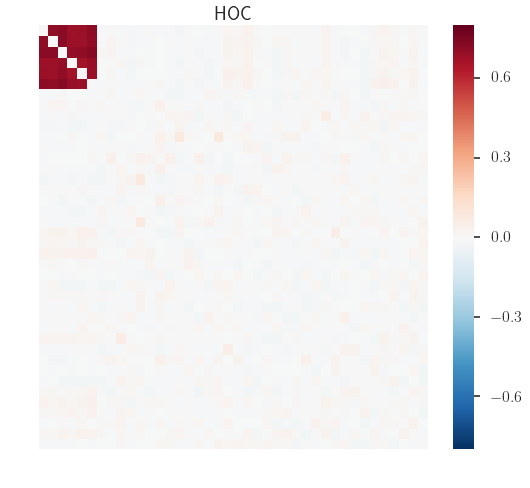

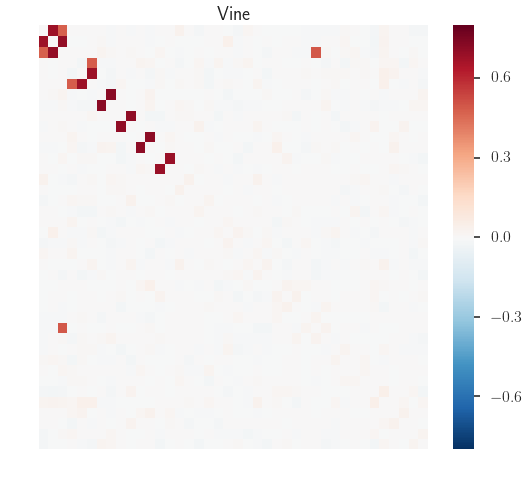

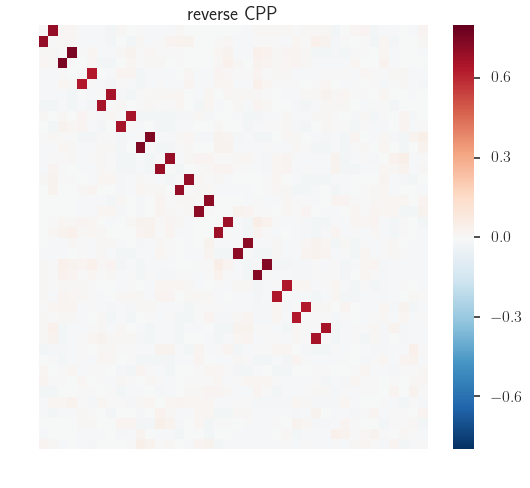

In [178]:
sns.set(style='ticks', palette='Set2', context='poster')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()
plot_matrix(cpp_mat, ax=ax, remove_autocorr=True, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.set_title('HOC')
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccmatrix_hoc_comp.png')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()
plot_matrix(vine_mat, ax=ax, remove_autocorr=True, cluster=True, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.set_title('Vine')
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccmatrix_vine_comp.png')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()
rcpp_mat = corr_matrix(model_pwc.spiketrains, binsize=binsize)
plot_matrix(rcpp_mat, ax=ax, remove_autocorr=True, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.set_title('reverse CPP')
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccmatrix_rcpp_comp.png')


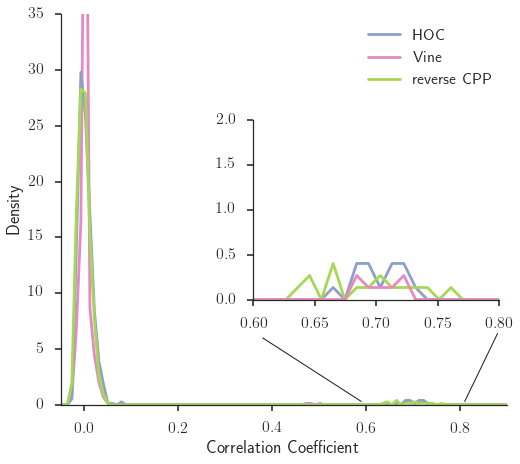

In [177]:
test = m2m_cov_ks_test_2msbins_100sample(model_hoc)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
edges = np.linspace(-.05,.9,100)


hist, _ = np.histogram(vine_mat[np.triu_indices(len(vine_mat), 1)], bins=edges, density=True)
hist = np.append(np.append(0., hist), 0.)
dx = np.diff(edges)[0]
xvalues = edges[:-1] + dx / 2.
xvalues = np.append(np.append(xvalues[0] - dx, xvalues), xvalues[-1] + dx)
ax.plot(xvalues, hist, label='Vine', color=c_vine)
plt.legend()
sns.despine()

test.visualize_samples(model_pwc, ax=ax, bins=edges, palette=[c_cpp,c_pwc], var_name='Correlation Coefficient', 
                      sample_names=['HOC', 'reverse CPP'])

insaxes = inset_axes(ax, width="55%", height=2.5, loc=5)
test.visualize_sample(model=model_pwc, ax=insaxes, bins=edges, palette=[c_hoc, c_pwc])
insaxes.plot(xvalues, hist, label='Vine', color=c_vine)

insaxes.set_xlim((0.6,0.8))
insaxes.set_ylim(0,2)
insaxes.set_xlabel('')
insaxes.set_ylabel('')
insaxes.legend().set_visible(False)
sns.despine(ax=insaxes)

ax.plot([.38, .59], [6, .3], 'k-', lw=1)
ax.plot([.81, .88], [.3, 6.4], 'k-', lw=1)

ax.set_xlim((-.05,.9))
ax.set_ylim((0,35))

h, l = ax.get_legend_handles_labels()
ax.legend([h[1],h[0],h[2]], [l[1],l[0],l[2]])

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/dist_hoc_vine_rcpp.pdf', bbox_inches='tight')

## Spatio-temporal Patterns

In [2]:
size = 10
A = 10
cc = .8
rate = 10*Hz
tstart = 0*ms
tstop = 5000*ms
binsize = 2*ms

c_st = sns.color_palette('Set2')[2]
c_cpp = sns.color_palette('Set2')[4]

model_st = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='spatio_temporal', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='ST', 
                                      max_pattern_length=100*ms, color=c_st)

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[],
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='HPP', color=c_cpp)

/usr/local/lib/python2.7/dist-packages/quantities/quantity.py:321: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)


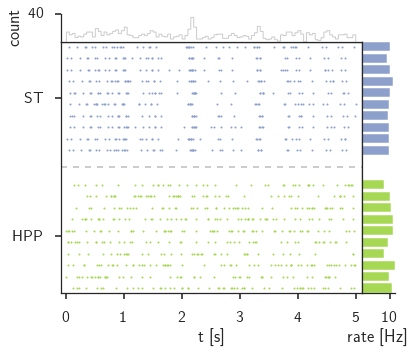

In [4]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

ax, axhistx, axhisty = rasterplot(model_cpp.spiketrains + model_st.spiketrains, ax=ax, key_list=['Model', 'Assembly'], 
           groupingdepth=1, spacing=2, palette=[c_cpp, c_st], colorkey='Model', pophist_mode='total',
           labelkey=0, context='poster')
ax.set_xticklabels([0,0,1,2,3,4,5])
axhisty.set_xticks([0.01])
axhisty.set_xticklabels([10])
axhisty.set_xlabel('rate [Hz]')
axhistx.set_ylabel('count')
ax.set_xlabel('t [s]')
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/rasterplot_spatio-temporal.pdf', bbox_inches='tight')

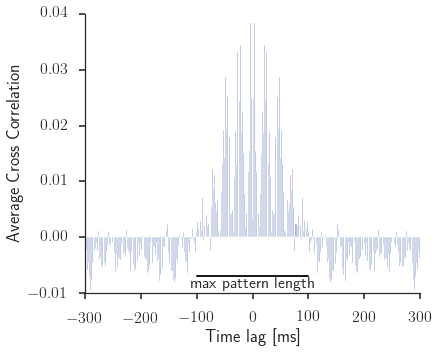

In [9]:
from blaustein_calc_pop_cch import _calculate_multi_cch
from validation.calc_popcch_marginals import summed_pop_cch

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
sns.despine()

cch_array = _calculate_multi_cch(model_st.spiketrains, maxlag=150, blaustein=False)

summed_pop_cch(cch_array, plot=True, ax=ax, binsize=2*ms, average=True, color=c_st);

ax.plot([-100,100], [-.007]*2, 'k-', lw=2)
ax.text(-110, -.009, 'max pattern length', fontsize=16)#, transform=ax.transAxes)

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/popcch_spatio-temporal.pdf', bbox_inches='tight')